In [7]:
import pandas as pd
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

In [148]:

data = []

def calculate_angle(x, y):
    from numpy import arctan2, sqrt
    new_x = 120 - x
    new_y = abs(y - 40)
    # The expression for tan(theta)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    
    # Calculate theta using the arctan2 function to handle the correct quadrant
    theta = arctan2(tan_theta, sqrt(1 + tan_theta**2))
    
    return math.degrees(theta)

def calculate_dist (x ,y):
    dist = ((x - 120)**2 + (y -40)**2)**0.5
    return dist


for i in range(len(damallsvenskan) - 1):
    if damallsvenskan.iloc[i]['action'] == 'Shot' and damallsvenskan.iloc[i+1]['action'] != 'Goal':
        data.append({'x': damallsvenskan.iloc[i]['xpos'] * 1.2, 'y' : damallsvenskan.iloc[i]['ypos'] * 0.8, 'goal': 0, 'header': damallsvenskan.iloc[i]['header'], 'angle': calculate_angle(damallsvenskan.iloc[i]['xpos'], damallsvenskan.iloc[i]['ypos']), 'distance': calculate_dist(damallsvenskan.iloc[i]['xpos'], damallsvenskan.iloc[i]['ypos'])})

for i in range(len(damallsvenskan) - 1):
    if damallsvenskan.iloc[i]['action'] == 'Shot' and damallsvenskan.iloc[i+1]['action'] == 'Goal':
        data.append({'x': damallsvenskan.iloc[i]['xpos'] * 1.2, 'y' : damallsvenskan.iloc[i]['ypos'] * 0.8, 'goal': 1, 'header': damallsvenskan.iloc[i]['header'], 'angle': calculate_angle(damallsvenskan.iloc[i]['xpos'], damallsvenskan.iloc[i]['ypos']), 'distance': calculate_dist(damallsvenskan.iloc[i]['xpos'], damallsvenskan.iloc[i]['ypos'])})


# # Scale the x coordinates
# x_shot_coordinates_damallsvenskan_scaled = [x * 120 / 100 for x in x_shot_coordinates_damallsvenskan]
# x_goal_coordinates_damallsvenskan_scaled = [x * 120 / 100 for x in x_goal_coordinates_damallsvenskan]

# # Scale the y coordinates
# y_shot_coordinates_damallsvenskan_scaled = [y * 80 / 100 for y in y_shot_coordinates_damallsvenskan]
# y_goal_coordinates_damallsvenskan_scaled = [y * 80 / 100 for y in y_goal_coordinates_damallsvenskan]



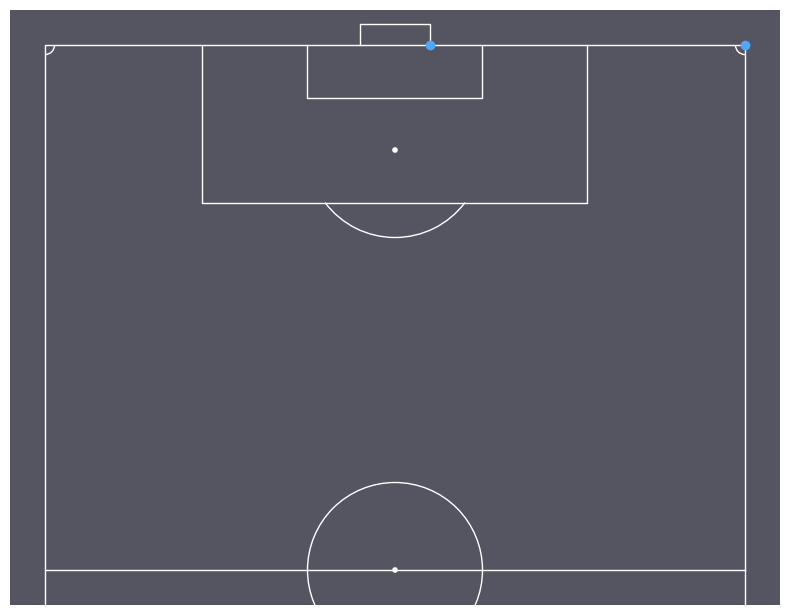

In [150]:

import pandas as pd
import numpy as np
import math
from mplsoccer import VerticalPitch, Pitch
width = 7.32
pitch = VerticalPitch(half=True, goal_type='box', corner_arcs=True, pitch_color='#545560', line_color='white', linewidth=1)

fig, ax = pitch.draw(figsize=(8,8))
sc = pitch.scatter(120, 44, 
                   ax=ax, color='#4da6ff', alpha=1.0, label='Shot')

sc = pitch.scatter(120, 80, 
                   ax=ax, color='#4da6ff', alpha=1.0, label='Shot')


data = pd.DataFrame(data)

# Separating the features and the target variable 
X = data[['distance','angle', 'header']]
Y = data[['goal']]





## Logistic Regression

In [149]:

from sklearn import preprocessing

regressor = LogisticRegression(random_state=0)
# Fit the regressor with x and y data
regressor.fit(X, Y)

xG_map = np.zeros((100,80))

for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y)])
        reshaped_arr = arr.reshape(1, -1)
        xG_map[x][y] = regressor.predict(reshaped_arr)



ValueError: X has 2 features, but LogisticRegression is expecting 3 features as input.

## Categorical gradient boosting

In [152]:
from catboost import Pool, CatBoostRegressor

xg_cat_boost = np.zeros((100,80))

model = CatBoostRegressor(iterations=3, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')

train_pool = Pool(X, 
                  Y)
model.fit(train_pool)

for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y), False])
        reshaped_arr = arr.reshape(1, -1)
        xg_cat_boost[x][y] = model.predict(reshaped_arr)

0:	learn: 0.3073202	total: 1.26ms	remaining: 2.51ms
1:	learn: 0.3059480	total: 2.43ms	remaining: 1.22ms
2:	learn: 0.3044045	total: 3.39ms	remaining: 0us


/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/4226289853.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xg_cat_boost[x][y] = model.predict(reshaped_arr)


## Bayesian regression

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import preprocessing

print(X)
x_normalized = preprocessing.normalize(X,norm="l2")
print(x_normalized)
reg = linear_model.BayesianRidge(compute_score=True)
reg.fit(x_normalized,Y)
xG_bayesian = np.zeros((100,80))
for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y)])
        reshaped_arr = arr.reshape(1, -1)
        xG_bayesian[x][y] = reg.predict(reshaped_arr)



        distance      angle
0       7.879086  36.299641
1      15.367498  20.144519
2      14.422205  25.467230
3       8.207314  32.261448
4      11.454257  15.950743
...          ...        ...
17387  15.939887   8.219666
17388  27.364210  11.870577
17389  10.829589  31.198571
17390  36.810868  10.566286
17391  48.373546   7.876793

[17392 rows x 2 columns]
[[0.21211755 0.97724416]
 [0.60652488 0.7950645 ]
 [0.49277396 0.87015735]
 ...
 [0.32792392 0.94470414]
 [0.96118598 0.27590128]
 [0.9870007  0.16071595]]


/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/151574716.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_bayesian[x][y] = reg.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/151574716.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_bayesian[x][y] = reg.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/151574716.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.

## Random forest

/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/3062900396.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_randomforest[x][y] = regr.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/3062900396.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_randomforest[x][y] = regr.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/3062900396.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprec

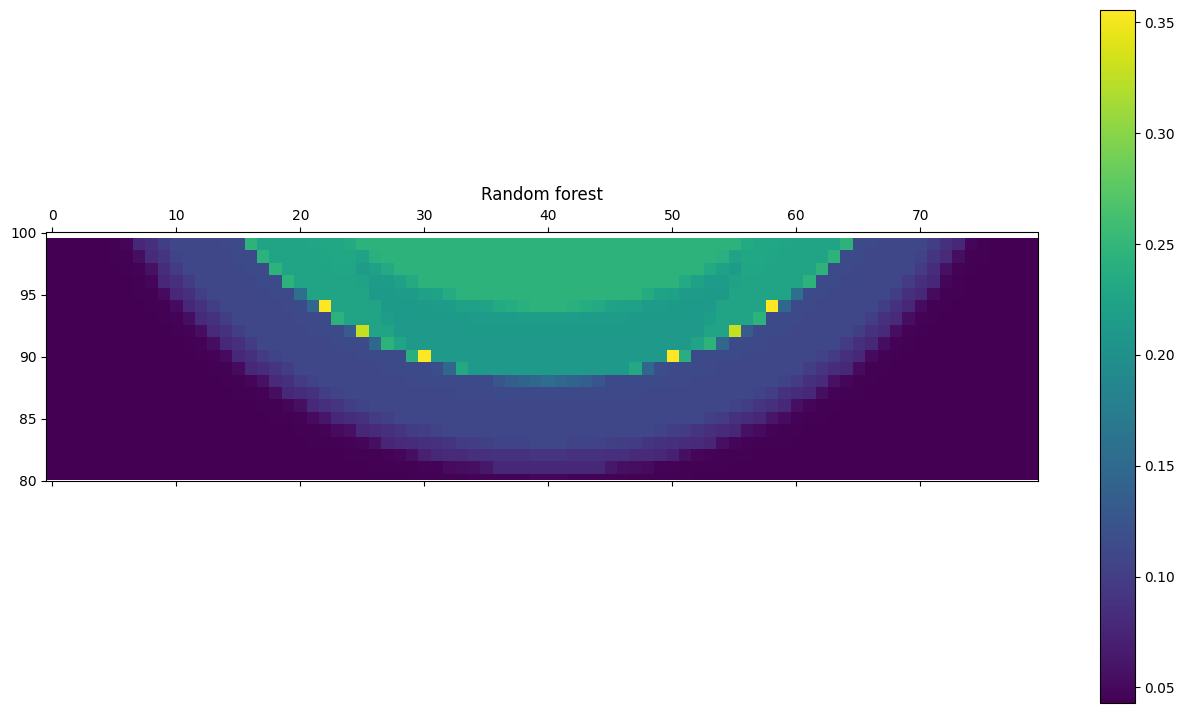

In [154]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)

regr.fit(X, Y)
xG_randomforest = np.zeros((100,80))
for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y), False])
        reshaped_arr = arr.reshape(1, -1)
        xG_randomforest[x][y] = regr.predict(reshaped_arr)


figure = plt.figure(figsize=(16,9))
axes = figure.add_subplot(1,1,1)
axes.set_title("Random forest")
axes.set_ylim(bottom=80,top=100)
caxes = axes.matshow(xG_randomforest, interpolation ='nearest', )
figure.colorbar(caxes)



## Plotting the heatmap for the xG

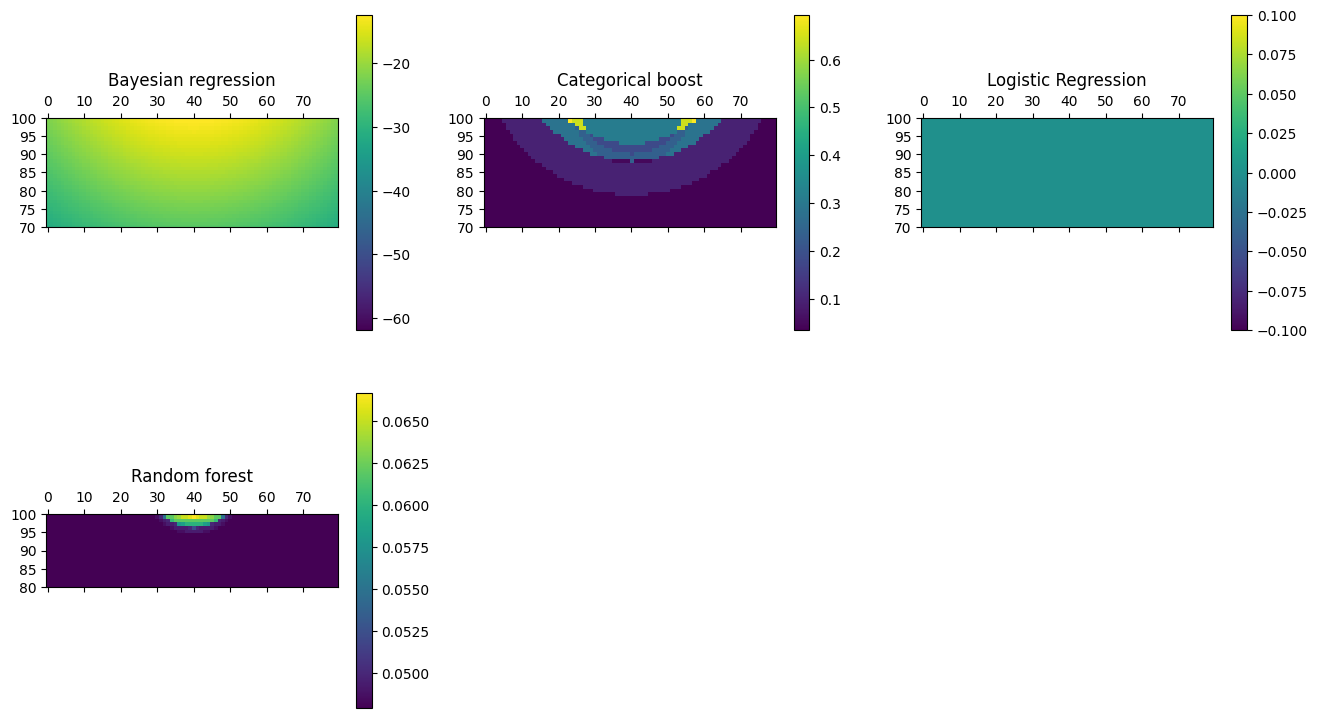

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal

figure = plt.figure(figsize=(16,9))
axes = figure.add_subplot(2,3,1)
axes.set_title("Bayesian regression")
axes.set_ylim(bottom=70,top=100)
caxes = axes.matshow(xG_bayesian, interpolation ='nearest', )
figure.colorbar(caxes)


axes2 = figure.add_subplot(2,3,2)
axes2.set_title("Categorical boost")
axes2.set_ylim(bottom=70,top=100)

caxes2 = axes2.matshow(xg_cat_boost, interpolation ='nearest')
figure.colorbar(caxes2)

axes3 = figure.add_subplot(2,3,3)
axes3.set_title("Logistic Regression")
axes3.set_ylim(bottom=70,top=100)

caxes3 = axes3.matshow(xG_map, interpolation ='nearest')
figure.colorbar(caxes3)

axes4 = figure.add_subplot(2,3,4)
axes4.set_title("Random forest")
axes4.set_ylim(bottom=80,top=100)
caxes4 = axes4.matshow(xG_randomforest, interpolation ='nearest')
figure.colorbar(caxes4)
plt.show()





In [ ]:

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.0251189436311402
Mean Squared Error: 0.08133839179774717
R-squared: 0.186577185953832
